In [170]:
import pyspark
import pyspark.sql.functions as sf
from pyspark.sql import Window
from plotnine import ggplot, geom_line, aes, geom_histogram

# change datetime parsing to legacy
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")


spark = (
    pyspark.sql.SparkSession.builder
    .master('local[2]') 
    .getOrCreate()
)

In [121]:
data_dir = '../data/tweets'

timestamp_format = "E MMM dd HH:mm:ss Z yyyy"

df = (
    spark.read.json(f'{data_dir}/2020-09-17.json')
        .select(
            'id',
            sf.to_timestamp(sf.col('created_at'), timestamp_format).alias('created_at'),
            sf.explode('entities.hashtags').alias('hashtags')
        )
        .selectExpr(
            'id',
            'created_at',
            'hashtags.text as hashtag'
        )
)

#  spark.read.json(filename)
#     .withColumn('created_at', sf.to_timestamp(sf.col('created_at'), timestamp_format))

df.limit(10).toPandas()

,id,created_at,hashtag
0,1306578867222540289,2020-09-17 15:00:51,광고
1,1306578867222540289,2020-09-17 15:00:51,ROSÉ
2,1306578867231117313,2020-09-17 15:00:51,광고
3,1306578867231117313,2020-09-17 15:00:51,BLACKPINK
4,1306578867201638403,2020-09-17 15:00:51,DeepStateExposed
5,1306578871412756485,2020-09-17 15:00:52,KeepShetlandCollegePublic
6,1306578871404449792,2020-09-17 15:00:52,RaphsodyOfRealities
7,1306578871400255488,2020-09-17 15:00:52,LatinosForTrump
8,1306578871395840002,2020-09-17 15:00:52,Master
9,1306578871395840002,2020-09-17 15:00:52,INDIAsMostRTedVIJAYSelfie


In [122]:
# Data Exploration

df.printSchema()

root
 |-- id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- hashtag: string (nullable = true)



In [ ]:
# extended text of tweet (if retweeted) inside of original tweet( extended tweet:full)_text
# retweet status?
# retwee_count
# favorite_count

# GOAL: try to trend the acceleration of an original tweet
#### - lower threshold, once crossed, the tweet is trending
#### - higher threshold, once crossed, the tweet is now popular

In [126]:
df_time = (
    df
        # .limit(10)
        .select(
            'id',
            'created_at',
            sf.year('created_at').alias('year'),
            sf.month('created_at').alias('month'),
            sf.dayofmonth('created_at').alias('day'),
            sf.hour('created_at').alias('hour'),
            'hashtag'
        )
)

df_time.toPandas()

,id,created_at,year,month,day,hour,hashtag
0,1306578867222540289,2020-09-17 15:00:51,2020,9,17,15,광고
1,1306578867222540289,2020-09-17 15:00:51,2020,9,17,15,ROSÉ
2,1306578867231117313,2020-09-17 15:00:51,2020,9,17,15,광고
3,1306578867231117313,2020-09-17 15:00:51,2020,9,17,15,BLACKPINK
4,1306578867201638403,2020-09-17 15:00:51,2020,9,17,15,DeepStateExposed
...,...,...,...,...,...,...,...
51539,1306613533132562434,2020-09-17 17:18:36,2020,9,17,17,TREASURE_ILoveYou
51540,1306613533132562434,2020-09-17 17:18:36,2020,9,17,17,사랑해_TREASURE_DDAY
51541,1306613533132562434,2020-09-17 17:18:36,2020,9,17,17,트레저
51542,1306613537339371520,2020-09-17 17:18:37,2020,9,17,17,superTENsuperone


In [175]:
df_hashtag_count = (
    df_time
        # .withColumn(
        #     'roll',
        #     sf.count('id').over(Window.partitionBy('hashtag', 'year', 'month', 'day', 'hour').orderBy('year', 'month', 'day', 'hour'))
        # )
        # .limit(50)
        .select(
            'id',
            'created_at',
            sf.window('created_at', '1 hour'),
            'hashtag',
            sf.count('id').over(Window.partitionBy('hashtag')).alias('hashtag_count'),
            sf.count('id').over(Window.partitionBy('hashtag', 'window').orderBy(sf.col('created_at'))).alias('hashtag_count_ot')
        )
        .sort('hashtag', 'created_at', ascending=True)
)

df_hashtag_count.toPandas()

,id,created_at,window,hashtag,hashtag_count,hashtag_count_ot
0,1306596705605910528,2020-09-17 16:11:44,"(2020-09-17 16:00:00, 2020-09-17 17:00:00)",100DaysOfCloud,1,1
1,1306580716889673738,2020-09-17 15:08:12,"(2020-09-17 15:00:00, 2020-09-17 16:00:00)",100DaysOfCode,12,1
2,1306588602177118208,2020-09-17 15:39:32,"(2020-09-17 15:00:00, 2020-09-17 16:00:00)",100DaysOfCode,12,2
3,1306593517922258944,2020-09-17 15:59:04,"(2020-09-17 15:00:00, 2020-09-17 16:00:00)",100DaysOfCode,12,3
4,1306594813962199044,2020-09-17 16:04:13,"(2020-09-17 16:00:00, 2020-09-17 17:00:00)",100DaysOfCode,12,1
...,...,...,...,...,...,...
51539,1306601684207120387,2020-09-17 16:31:31,"(2020-09-17 16:00:00, 2020-09-17 17:00:00)",𝙁𝘼𝙇𝙇𝙄𝙉,1,1
51540,1306583329945407490,2020-09-17 15:18:35,"(2020-09-17 15:00:00, 2020-09-17 16:00:00)",𝙃𝙧𝙞𝙩𝙝𝙞𝙠𝙍𝙤𝙨𝙝𝙖𝙣,1,1
51541,1306583329945407490,2020-09-17 15:18:35,"(2020-09-17 15:00:00, 2020-09-17 16:00:00)",𝙆𝙖𝙧𝙚𝙚𝙣𝙖,1,1
51542,1306583329945407490,2020-09-17 15:18:35,"(2020-09-17 15:00:00, 2020-09-17 16:00:00)",𝙋𝙧𝙞𝙮𝙖𝙣𝙠𝙖,1,1


22/09/09 21:45:55 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 980212 ms exceeds timeout 120000 ms
22/09/09 21:45:55 WARN SparkContext: Killing executors is not supported by current scheduler.


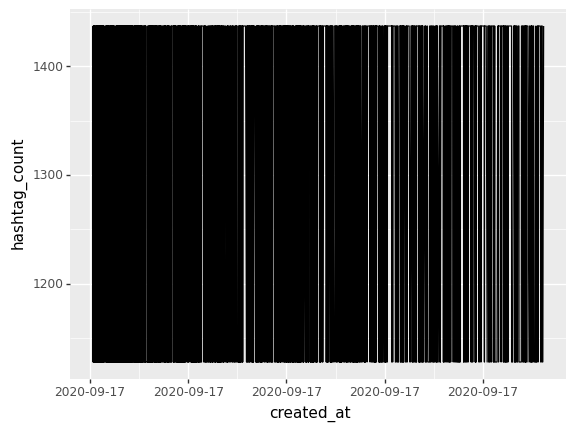

<ggplot: (721623779)>

In [174]:
# hashtag count histogram
# place a lower limit = not trending -> trending
# place an upper limit = trending -> popular
# maybe 2-3 stds as the bands?

# ultimately, a dashboard that would update as you slide over time
# count over time would represent the velocity of

(
    # df_hashtag_count
    #     .toPandas()
    
    ggplot(
        df_hashtag_count
            # .filter(sf.col('hashtag_count') > 5)
            .toPandas(),
        aes(x'hashtag_count'))
        + geom_histogram()
        # + stat_smooth(method='lm')
        # + facet_wrap('~gear')
 )

#  geom_line(mapping=None, data=None, stat='identity', position='identity',
#           na_rm=False, inherit_aes=True, show_legend=None, raster=False,
#           arrow=None, lineend='butt', linejoin='round', **kwargs)

In [25]:
# Proceesing Pipeline

# Read in all the data
#### Loop through json files and read each

# Flatten the data
#### Decide which fields are necessary to keep, discard the rest
#### Result is 2 dim table

# Fields to keep
# current tweet - created_at, id, text/original_full_text (if available), retweeted_status,
# current_retweent_count, current_favorite_count

# stuff inside original tweet, when retweeted


(
    df
        .limit(10)
        .selectExpr(
            'created_at as current_created_at',
            'id as current_id',
            'text as current_text',
            'retweeted_status',
            'retweeted_status.extended_tweet.full_text as original_text',
            'retweeted_status.retweet_count as original_retweet_count',
            'retweeted_status.favorite_count as original_favorit_count',
            'retweet_count as current_retweet_count',
            'favorite_count as current_favorite_count'
        )
        # .filter(sf.col('retweeted_status').isNull())
        .toPandas()
)



,current_created_at,current_id,current_text,retweeted_status,original_text,original_retweet_count,original_favorit_count,current_retweet_count,current_favorite_count
0,Thu Sep 17 13:00:51 +0000 2020,1306578867205926914,RT @RealCandaceO: Fun to consider that they’ve...,"(None, None, Thu Sep 17 13:00:38 +0000 2020, N...",Fun to consider that they’ve cancelled Aunt Je...,7.0,29.0,0,0
1,Thu Sep 17 13:00:51 +0000 2020,1306578867201748993,RT @LjsGoat: We all owe LeBron James an apolog...,"(None, None, Wed Sep 16 21:30:46 +0000 2020, N...",None,86.0,443.0,0,0
2,Thu Sep 17 13:00:51 +0000 2020,1306578867222728706,RT @lousnv: Click on the elephant \n\n ...,"(None, None, Tue Sep 15 22:33:28 +0000 2020, N...",None,80706.0,295387.0,0,0
3,Thu Sep 17 13:00:51 +0000 2020,1306578867193286657,RT @Quantum_King_: Me and my boy after splitti...,"(None, None, Wed Sep 16 22:53:50 +0000 2020, [...",None,17842.0,139199.0,0,0
4,Thu Sep 17 13:00:51 +0000 2020,1306578867201675264,@realDonaldTrump You are officially an evil pe...,None,None,NaN,NaN,0,0
5,Thu Sep 17 13:00:51 +0000 2020,1306578867222540289,RT @BLACKPINK: #광고 #ROSÉ is on the cover of EL...,"(None, None, Thu Sep 17 12:54:32 +0000 2020, [...",None,9989.0,25570.0,0,0
6,Thu Sep 17 13:00:51 +0000 2020,1306578867193294849,RT @taehyungedit: daddy 🤤 https://t.co/NzLvoZUeF9,"(None, None, Thu Sep 17 01:05:18 +0000 2020, [...",None,3920.0,11786.0,0,0
7,Thu Sep 17 13:00:51 +0000 2020,1306578867222581249,RT @dailykkyu: prince of bunny kingdom https:/...,"(None, None, Thu Sep 17 09:29:50 +0000 2020, [...",None,402.0,901.0,0,0
8,Thu Sep 17 13:00:51 +0000 2020,1306578867230916608,RT @CP_Union: We are excited to announce our s...,"(None, None, Thu Sep 17 12:00:00 +0000 2020, [...",We are excited to announce our speakers for Da...,16.0,10.0,0,0
9,Thu Sep 17 13:00:51 +0000 2020,1306578867214319616,I gotta wait till i get home to tweet about th...,None,None,NaN,NaN,0,0


In [12]:
(
    df
        .filter(sf.col('id') == 1306578867201675264)
        .select
        .toPandas()
)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,...,reply_count,retweet_count,retweeted,retweeted_status,source,text,timestamp_ms,truncated,user,withheld_in_countries
0,None,None,Thu Sep 17 13:00:51 +0000 2020,"[17, 118]","([], None, [], [], [(25073877, 25073877, [0, 1...",None,None,0,False,low,...,0,0,False,None,"<a href=""http://twitter.com/download/iphone"" r...",@realDonaldTrump You are officially an evil pe...,1600347651659,False,"(False, Sun Aug 15 01:37:08 +0000 2010, True, ...",None


In [ ]:
# Build the acceleration trend

# Place thresholds on the accleration trend based on analysis

# Identify the topics within that band

# Visualization: List of TOPICS, and see how they move over time (sorted)